# Solutions for the `exercise_tenpy.ipynb` notebook

Uncomment and run the cells below (removing the `#`) when running this notebook on https://colab.research.google.com.

Alternatively, you can run this notebook locally with jupyter, provided that you have the `toycodes` subfolder from 
https://github.com/tenpy/tenpy_toycodes
in the same folder as your notebook.

In [1]:
#!pip install git+https://github.com/tenpy/tenpy_toycodes.git
#!pip install git+https://github.com/tenpy/tenpy.git

# use `pip uninstall tenpy-toycodes physics-tenpy` to remove them again.

You can add your code below by inserting additional cells as neccessary and running them (press Shift+Enter).

**DISCLAIMER**: Like for the toy codes, we only use very small bond dimensions here. For state-of-the-art MPS calculations (especially for cylinders towards 2D), `chi` should be significantly larger, often on the order of several 1000s.

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pprint import pprint

np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [3]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd, dmrg, tdvp
from tenpy.networks.site import SpinHalfSite, SpinSite, FermionSite
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

tenpy.tools.misc.setup_logging(to_stdout="INFO")

# Overview

The source code of TeNPy is at https://github.com/tenpy/tenpy/; 
you can find links to the documentation and the forum in the Readme there.

The [**documentation**](https://tenpy.readthedocs.io) is roughly split into the "User guide" (upper part in the left side-bar) and the reference of all the functions and classes (lower part).



## Exercise(s)

Read the [overview](https://tenpy.readthedocs.io/en/latest/intro/overview.html) of the TeNPy documentation.

Whenever you hit an example code, try to copy it here and run it.

Try to modify it slightly and try to rerun it; for example try to calculate the overlap `<v|v>` in the first example.

# Initializing a Model

In TeNPy, the model defines the Hilbert space and local operators, and ultimately fixes whether charge conservation is used. Therefore, you should usually start with the initialization of the model.
There are many predefined models in `tenpy.models`, that you can often just use.

We will first initialize the transverse field Ising model. One advantage of TeNPy is that it can exploit (abelian) charge conservation for speedups, e.g. the transverse field Ising model preserves an overall spin parity. However, this requires the form 
$$ H = - J \sum_{i} \sigma^x_i \sigma^x_{i+1} - g \sum_{i} \sigma^z_i  \textrm{ in TeNPy}$$
compared to the form 
$$ H = - J \sum_{i} \sigma^z_i \sigma^z_{i+1} - g \sum_{i} \sigma^x_i \textrm{  (not suitable for charge conservation)}$$ you might be more familiar with, where X and Z are exchanged.

In TeNPy, allmost all parmaters can be changed dynamically through options. Default parameters are written back into the dictionaries.

In [4]:
model_params = {
    'L': 20,
    'g': 1.0,
    'bc_MPS': 'finite',
    'conserve': 'best'
}
model = TFIChain(model_params)
# you can now print the default parameters used:
print("used parameters, including default/not specified ones:")
pprint(model_params)

INFO    : TFIChain: reading 'bc_MPS'='finite'
INFO    : TFIChain: reading 'conserve'='best'
INFO    : TFIChain: set conserve to parity
INFO    : TFIChain: reading 'L'=20
INFO    : TFIChain: reading 'g'=1.0
used parameters, including default/not specified ones:
{'J': 1.0,
 'L': 20,
 'bc_MPS': 'finite',
 'bc_x': 'open',
 'conserve': 'best',
 'explicit_plus_hc': False,
 'g': 1.0,
 'lattice': <class 'tenpy.models.lattice.Chain'>,
 'order': 'default',
 'sort_mpo_legs': False}


Given the model, one can easily initialize a product state, e.g. for the Neel state:

In [5]:
p_state = ['up', 'down'] * (model.lat.N_sites//2)
psi = MPS.from_product_state(model.lat.mps_sites(), p_state, bc=model.lat.bc_MPS)


Measuring expectation values is also similar to the toycode. However, we can even specify the local operators (defined in the sites) as strings:

In [6]:
print("<sigmaz> = ", psi.expectation_value('Sigmaz'))
print("S = ", psi.entanglement_entropy())

<sigmaz> =  [ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
S =  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


### Exercise

Check the [`model.bond_energies`](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.model.NearestNeighborModel.html#tenpy.models.model.NearestNeighborModel.bond_energies) for the Neel state and make sure it matches what you expect.



In [7]:
E = model.bond_energies(psi)
print("energy Neel:", E)

energy Neel: [-0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5]


# Running DMRG

Given the model and state, running DMRG isn't hard.
Again, there are many (default) parameters for fine-tuning, see [this full option list](https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.dmrg.TwoSiteDMRGEngine.html#cfg-config-TwoSiteDMRGEngine) for details.

In [8]:
p_state = ['up'] * model.lat.N_sites
psi = MPS.from_product_state(model.lat.mps_sites(), p_state, bc=model.lat.bc_MPS)
algorithm_params = {
    'trunc_params': {
        'chi_max': 30,
        'svd_min': 1.e-7,
    },
    'max_sweeps': 40,
}
eng = dmrg.TwoSiteDMRGEngine(psi, model, algorithm_params)
E, psi = eng.run()

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'max_sweeps'=40
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=30
INFO    : trunc_params: reading 'svd_min'=1e-07
INFO    : checkpoint after sweep 1
energy=-25.1067276087268887, max S=0.3801726459659348, age=20, norm_err=5.0e-02
Current memory usage 127.1MB, wall time: 0.2s
Delta E = nan, Delta S = 3.5048e-01 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 2.1316e-14
chi: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-25.1077971109763993, max S=0.4437610868090505, age=20, norm_err=3.0e-04
Current memory usage 129.7MB, wall time: 0.5s
Delta E = -1.0695e-03, Delta S = 4.3710e-02 (per sweep)
max trunc_err = 9.4252e-15, max E_trunc = 9.9476e-14
chi: [2, 4, 8, 12, 12, 13, 13, 14, 14, 14, 14, 14, 13, 13, 12, 12, 8, 4, 2]
INFO    :

### Exercise

Run DMRG for `'infinite'` MPS. 
(You need to initialize a new model, state, and DMRG engine for this.)


In [9]:
from toycodes import tfi_exact

print("E_exact =", tfi_exact.infinite_gs_energy(model_params['J'], model_params['g']))

E_exact = -1.2732395447351625


In [10]:
model_params = {
    'L': 2,
    'g': 1.2,
    'bc_MPS': 'infinite',
    'conserve': 'best'
}
model = TFIChain(model_params)

p_state = ['up', 'up'] * (model.lat.N_sites // 2)
psi = MPS.from_product_state(model.lat.mps_sites(), p_state, bc=model.lat.bc_MPS)
algorithm_params = {
    'trunc_params': {
        'chi_max': 30,
        'svd_min': 1.e-7,
    },
    'max_sweeps': 40,
}
eng = dmrg.TwoSiteDMRGEngine(psi, model, algorithm_params)
E, psi = eng.run()

INFO    : TFIChain: reading 'bc_MPS'='infinite'
INFO    : TFIChain: reading 'conserve'='best'
INFO    : TFIChain: set conserve to parity
INFO    : TFIChain: reading 'L'=2
INFO    : TFIChain: reading 'g'=1.2
INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=30
INFO    : trunc_params: reading 'svd_min'=1e-07
INFO    : TwoSiteDMRGEngine: reading 'max_sweeps'=40
INFO    : Running sweep with optimization
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=-1.4196192748981851, max S=0.2533554575580502, age=128, norm_err=2.2e-12
Current memory usage 130.6MB, wall time: 0.4s
Delta E = nan, Delta S = 2.5336e-02 (per sweep)
max trunc_err = 3.6232e-15, max E_trunc = 1.2790e-13
chi: [18, 18]
INFO    : Running sweep with optimization
INFO    : start environment_sweep
INFO    : checkpoint after sweep 20
energy=-1.4196192748981318, max S=0.2533554570964506, age=

### Exercise

Reproduce the phase-diagram plot of the transverse field Ising model from the toy code noteboook with TeNPy.


In [11]:
#gs = [0.1, 0.5, 1.0, 1.5, 2.0]
gs = np.linspace(0., 2., 21)
entropies = []
vals_X = []
vals_Z = []
corrs_XX = []


for g in gs:
    model = TFIChain({'L': 2, 'J': 1., 'g': g, 'bc_MPS': 'infinite'})
    psi = MPS.from_product_state(model.lat.mps_sites(), ['up', 'up'], bc=model.lat.bc_MPS)
    eng = dmrg.TwoSiteDMRGEngine(psi, model, algorithm_params)
    E, psi = eng.run()
    entropies.append(np.max(psi.entanglement_entropy()))
    vals_X.append(np.mean(psi.expectation_value("Sigmax")))
    vals_Z.append(np.mean(psi.expectation_value("Sigmaz")))
    corrs_XX.append(psi.correlation_function("Sigmax", "Sigmax", [0], [20]).item())

    

INFO    : TFIChain: reading 'bc_MPS'='infinite'
INFO    : TFIChain: reading 'L'=2
INFO    : TFIChain: reading 'J'=1.0
INFO    : TFIChain: reading 'g'=0.0
INFO    : TwoSiteDMRGEngine: reading 'diag_method'='default'
INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<5 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'combine'=False
INFO    : TwoSiteDMRGEngine: subconfig 'lanczos_params'=Config(<9 options>, 'lanczos_params')
INFO    : TwoSiteDMRGEngine: reading 'chi_list'=None
INFO    : TwoSiteDMRGEngine: reading 'start_env'=1
INFO    : start environment_sweep
INFO    : TwoSiteDMRGEngine: reading 'chi_list_reactivates_mixer'=True
INFO    : TwoSiteDMRGEngine: reading 'P_tol_to_trunc'=0.05
INFO    : TwoSiteDMRGEngine: reading 'P_tol_min'=4.999999999999999e-16
INFO    : TwoSiteDMRGEngine: reading 'P_tol_max'=0.0001
INFO    : TwoSiteDMRGEngine: reading 'E_tol_to_trunc'=None
INFO    : TwoSiteDMRGEngine: reading 'N_sweeps_check'=10
INFO    : TwoSiteDMRGEngine: reading 

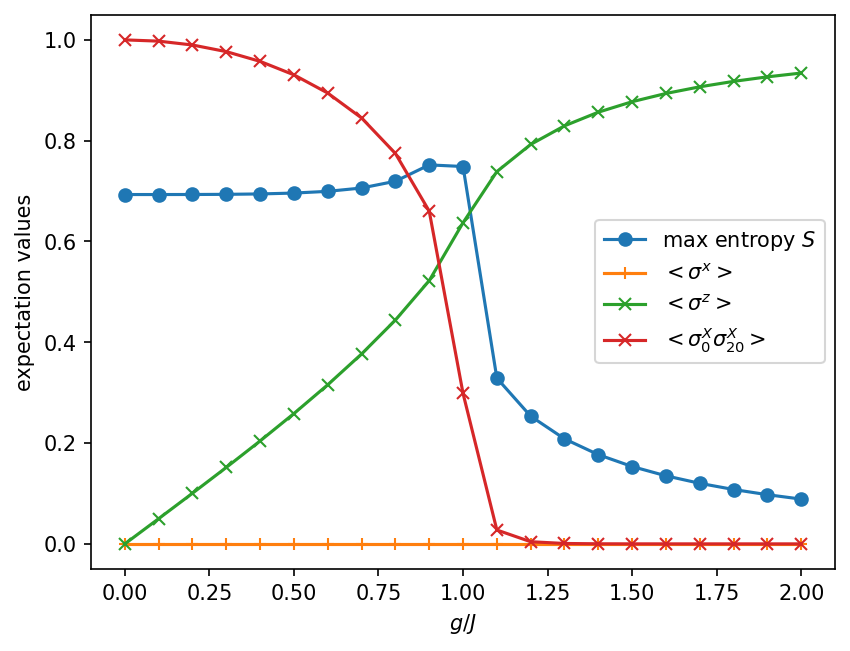

In [12]:
plt.plot(gs, entropies, marker='o', label='max entropy $S$')
# plot expecation values of sigmax and sigmaz as well
plt.plot(gs, vals_X, marker='+', label=r'$<\sigma^x>$')
plt.plot(gs, vals_Z, marker='x', label=r'$<\sigma^z>$')
plt.plot(gs, corrs_XX, marker='x', label=r'$<\sigma^X_0 \sigma^X_{20}>$')


plt.xlabel('$g/J$')
plt.ylabel('expectation values')
plt.legend(loc='best')


### Advanced exercises - if you're an expert and have time left ;-)

These examples only scratch on the surface of what you can do with TeNPy.
- There are plenty of [more examples](https://tenpy.readthedocs.io/en/latest/examples.html) in the documentation.  Take a look at them!
- Try to learn how to define your own model from the TeNPy documentation. Define a model for the XX Chain.
- Look at the documentation how to run TEBD and TDVP and reproduce the time-evolution plot for S(t) from the toy    code notebook.
- Learn how to save and load data in TeNPy.